Flight delay prediction using XGBoost Decision Tree

In [293]:
#Import all the required dependancies
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import SMOTEN, SMOTER

In [294]:
#Fetching data via a API call to aviationstock.com  that allows to fetch data using API Key.
import requests

# Replace with your API key, removed here as it is not recommended
API_KEY = "ac172c3422f95f3b7d91b3df3dabb2ea" 

# Define API endpoint for delayed flights
url = f"http://api.aviationstack.com/v1/flights?access_key={API_KEY}&flight_status=landed"

# Make the API request
response = requests.get(url)

# Check response
if response.status_code == 200:
    flights = response.json()["data"]
    print(f"Total delayed flights: {len(flights)}")
    print(flights[:3])  # Show first 3 records
else:
    print(f"Error: {response.status_code}, {response.text}")


Total delayed flights: 100
[{'flight_date': '2025-02-18', 'flight_status': 'landed', 'departure': {'airport': 'Broome', 'timezone': 'Australia/Perth', 'iata': 'BME', 'icao': 'YBRM', 'terminal': None, 'gate': None, 'delay': None, 'scheduled': '2025-02-18T05:00:00+00:00', 'estimated': '2025-02-18T05:00:00+00:00', 'actual': '2025-02-17T05:28:00+00:00', 'estimated_runway': '2025-02-17T05:28:00+00:00', 'actual_runway': '2025-02-17T05:28:00+00:00'}, 'arrival': {'airport': 'Kununurra', 'timezone': 'Australia/Perth', 'iata': 'KNX', 'icao': 'YPKU', 'terminal': None, 'gate': None, 'baggage': None, 'delay': 38, 'scheduled': '2025-02-17T06:37:00+00:00', 'estimated': '2025-02-17T06:37:00+00:00', 'actual': '2025-02-17T07:14:00+00:00', 'estimated_runway': '2025-02-17T07:14:00+00:00', 'actual_runway': '2025-02-17T07:14:00+00:00'}, 'airline': {'name': 'empty', 'iata': None, 'icao': None}, 'flight': {'number': None, 'iata': None, 'icao': None, 'codeshared': None}, 'aircraft': None, 'live': None}, {'flig

In [295]:
# Extract relevant fields
flight_rows = []
for flight in flights:
    departure = flight["departure"]
    arrival = flight["arrival"]
    airline = flight["airline"]
    flight_info = flight["flight"]

    flight_rows.append({
        "flight_date": flight["flight_date"],
        "flight_number": flight_info["number"],
        "airline": airline["name"],
        "departure_airport": departure["airport"],
        "arrival_airport": arrival["airport"],
        "scheduled_departure": departure["scheduled"],
        "actual_departure": departure["actual"],
        "departure_delay": departure["delay"],
        "scheduled_arrival": arrival["scheduled"],
        "actual_arrival": arrival["actual"],
        "arrival_delay": arrival["delay"]
    })

# Convert to DataFrame
df = pd.DataFrame(flight_rows)

# Convert time columns to datetime format
df["scheduled_departure"] = pd.to_datetime(df["scheduled_departure"])
df["actual_departure"] = pd.to_datetime(df["actual_departure"])
df["scheduled_arrival"] = pd.to_datetime(df["scheduled_arrival"])
df["actual_arrival"] = pd.to_datetime(df["actual_arrival"])

# Fill missing delay values with 0 (flights that were on time)
df["departure_delay"] = df["departure_delay"].fillna(0)
df["arrival_delay"] = df["arrival_delay"].fillna(0)

# Compute total delay (target variable for prediction)
df["total_delay"] = df["arrival_delay"] - df["departure_delay"]

# Preview DataFrame
print(df.head())
print(type(df))

  flight_date flight_number            airline             departure_airport  \
0  2025-02-18          None              empty                        Broome   
1  2025-02-17          5803  Hawaiian Airlines                       Fukuoka   
2  2025-02-17          1650       Bulgaria Air                  Fontanarossa   
3  2025-02-17           217            Jetstar  Narita International Airport   
4  2025-02-17          9244   Garuda Indonesia                      Schiphol   

                    arrival_airport       scheduled_departure  \
0                         Kununurra 2025-02-18 05:00:00+00:00   
1                             Itami 2025-02-17 14:55:00+00:00   
2     Leonardo Da Vinci (Fiumicino) 2025-02-17 06:05:00+00:00   
3              Kansai International 2025-02-17 07:00:00+00:00   
4  Düsseldorf International Airport 2025-02-17 10:10:00+00:00   

           actual_departure  departure_delay         scheduled_arrival  \
0 2025-02-17 05:28:00+00:00              0.0 2025-02-1

In [296]:
# Load Data and convert to formats accordingly
df['actual_departure'] = pd.to_datetime(df['actual_departure'], errors='coerce', utc=True)
df['scheduled_departure'] = pd.to_datetime(df['scheduled_departure'], errors='coerce', utc=True)
df['actual_departure'] = df['actual_departure'].dt.tz_localize(None)
df['scheduled_departure'] = df['scheduled_departure'].dt.tz_localize(None)
# print(df.dtypes)

df['departure_hour'] = df['actual_departure'].dt.hour.fillna(0).astype(int)
df['day_of_week'] = df['actual_departure'].dt.dayofweek

df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_peak_hour'] = ((df['departure_hour'].between(7, 9)) | (df['departure_hour'].between(17, 20))).astype(int)
df['weekend_peak_hour'] = df['is_weekend'] & df['is_peak_hour']

df['avg_past_delay'] = df.groupby(['airline', 'departure_airport', 'arrival_airport'])['departure_delay'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
df.fillna(0, inplace=True)

/var/folders/9m/xmb6cfqs55d_cp4t3s4m_9180000gn/T/ipykernel_14240/4179020382.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  df.fillna(0, inplace=True)
/var/folders/9m/xmb6cfqs55d_cp4t3s4m_9180000gn/T/ipykernel_14240/4179020382.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.fillna(0, inplace=True)


In [297]:
# Encoding categorical variables
label_encoders = {}
categorical_cols = ['airline', 'departure_airport', 'arrival_airport']
for col in categorical_cols:
    df[col] = df[col].astype(str)  # Ensure consistent data type
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [298]:
#Selecting features and targets
features = ['airline', 'departure_airport', 'arrival_airport', 'departure_delay', 'departure_hour', 'day_of_week', 'is_weekend', 'is_peak_hour', 'weekend_peak_hour', 'avg_past_delay']
target = 'total_delay'
X = df[features]
y = df[target]

In [299]:
#Splitting data into train and test data
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.2, random_state=42)

In [300]:
#Train XGBOOST model
xmodel = xgb.XGBRFRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)

xmodel.fit(Xtrain,ytrain)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, ...)

In [301]:
#Predictions
ypred = xmodel.predict(Xtest)

In [302]:
#Evaluate metrics
mae = mean_absolute_error(ytest,ypred)
mse = mean_squared_error(ytest,ypred)
rmse = np.sqrt(mse)
r2 = r2_score(ytest,ypred)

print(f"MAE: {mae}, MSE : {mse}, RMSE: {rmse}, R2 score: {r2}")

MAE: 9.760194206237793, MSE : 190.3006085572647, RMSE: 13.794948660914425, R2 score: 0.07237178831199631


<Figure size 800x500 with 0 Axes>

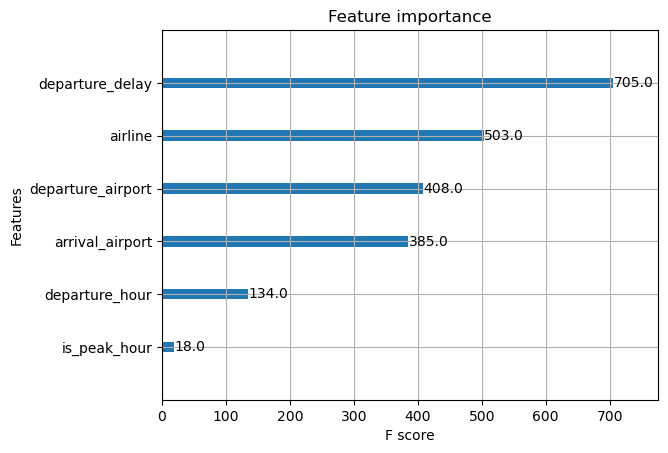

In [303]:
#Feature importance plot
plt.figure(figsize=(8,5))
xgb.plot_importance(xmodel,importance_type='weight')
plt.show()

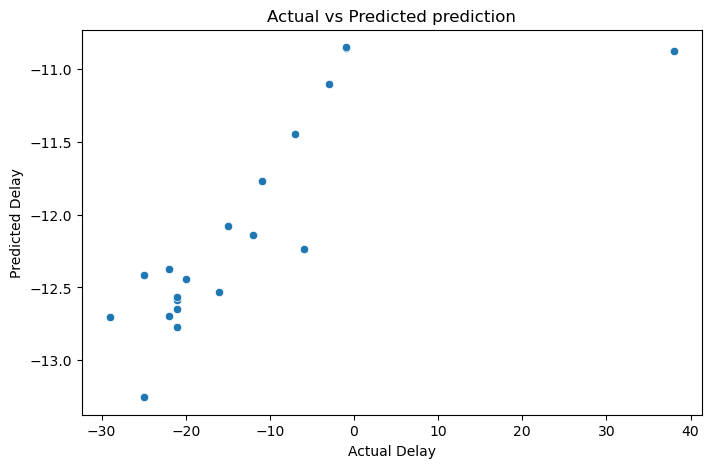

In [ ]:
#Scatter plot of actual vs predicted
def plot_predictions(ytest,ypred):
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=ytest,y=ypred)
    plt.xlabel("Actual Delay")
    plt.ylabel("Predicted Delay")
    plt.title("Actual vs Predicted prediction")
    plt.show()

plot_predictions(ytest,ypred)


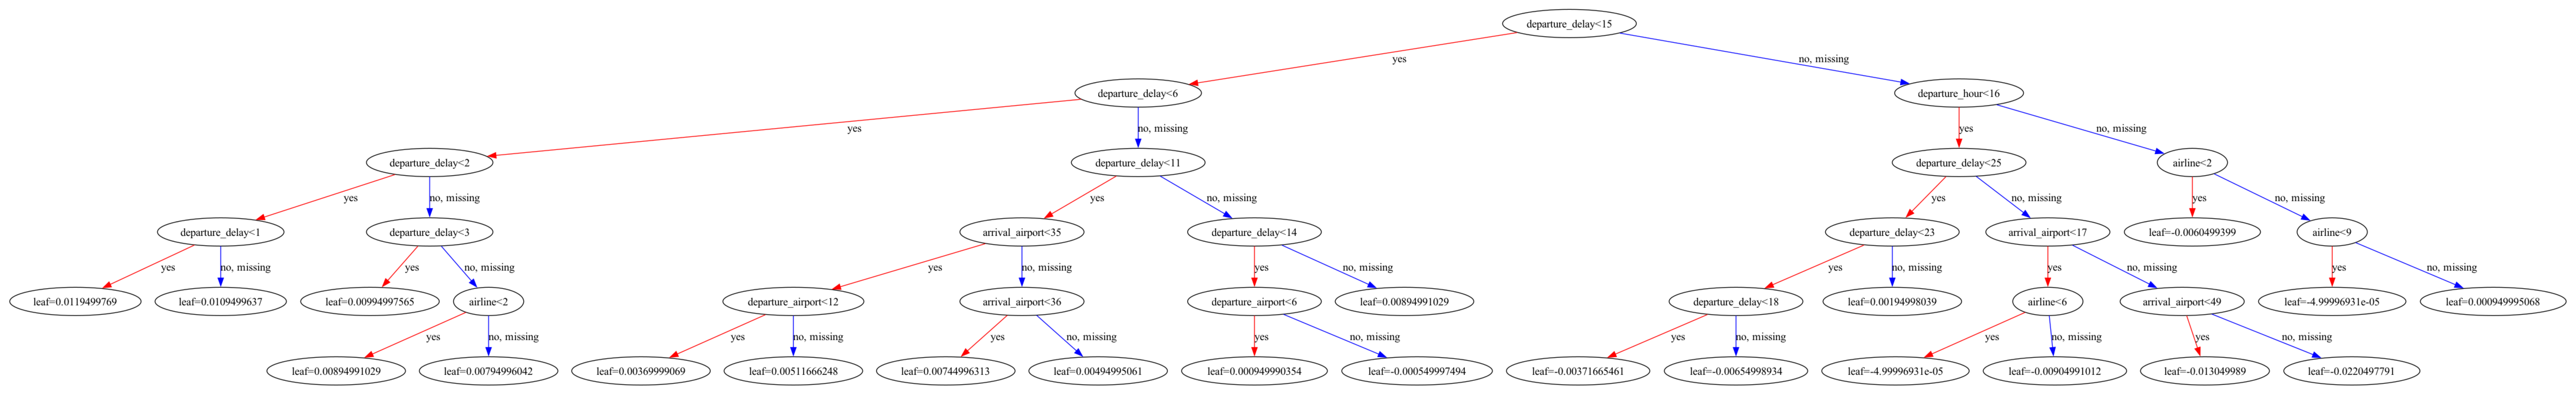

In [317]:
# Tree Plot Visualization
plt.figure(figsize=(50,40),dpi=200)
plot_tree(xmodel, num_trees=0,ax=plt.gca(), show_info=['impurity', 'weight', 'cover', 'total_gain', 'total_weight'])
plt.show()

In [306]:
#Predict flight delay based on the input
import sys
def user_input_predict():
    try:
        airline = input("Enter Airline: ")
        departure_airport = input("Enter Departure Airport: ")
        arrival_airport = input("Enter Arrival Airport: ")
        departure_delay = float(input("Enter departure delay (minutes): "))
        departure_hour = int(input("Enter Departure Hour (0-23): "))
        day_of_week = int(input("Enter Day of Week (0=Monday, 6=Sunday): "))
        is_weekend = 1 if day_of_week >= 5 else 0
        is_peak_hour = 1 if (7 <= departure_hour <= 9 or 17 <= departure_hour <= 20) else 0

        if airline not in label_encoders['airline'].classes_ or \
            departure_airport not in label_encoders['departure_airport'].classes_ or \
            arrival_airport not in label_encoders['arrival_airport'].classes_:
                print("Invalid input. Please enter correct airline and airport names.")
                return

        input_Data = np.array([[
            label_encoders['airline'].transform([airline])[0],
            label_encoders['departure_airport'].transform([departure_airport])[0],
            label_encoders['arrival_airport'].transform([arrival_airport])[0],
            departure_delay,
            departure_hour,
            day_of_week,
            is_weekend,
            is_peak_hour
        ]])
        predicted_delay = xmodel.predict(input_Data)[0]
        print(f"Predicted Total Delay for input provided : {predicted_delay:.2f} minutes")
        return predicted_delay
    except Exception as e:
            print(f"Error: {e}", file=sys.stderr)


In [307]:
user_input_predict() #This is the function define above to predict individual values of features entered by user to predict target

To improve model performance introducing SMOTE and RandomsearchCV tuning

In [308]:
# Filter out extremely rare classes before applying SMOTE
min_samples_threshold = 2
value_counts = ytrain.value_counts()
rare_classes = value_counts[value_counts < min_samples_threshold].index
mask = ~ytrain.isin(rare_classes)
X_train, y_train = Xtrain[mask], ytrain[mask]

# Apply SMOTE for class balancing
smote = SMOTE(k_neighbors=1,sampling_strategy='auto')
X_train, y_train = smote.fit_resample(X_train, y_train)

/Users/prudhvileo/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [320]:
# Hyperparameter Tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

rsCV_model = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror'),
    param_distributions=param_dist,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1,
    n_iter=10
)
rsCV_model.fit(Xtrain, ytrain)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 300, 500],
                                        'subsample': [0.7, 0.8, 1.0]},
                   scoring='r2', verbose=1)

In [321]:
# Train with best parameters
tuned_model = rsCV_model.best_estimator_
tuned_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [322]:
# Evaluate Optimized Model
y_pred_optimized = tuned_model.predict(Xtest)
print(f"Optimized MAE: {mean_absolute_error(ytest, y_pred_optimized)}")
print(f"Optimized MSE: {mean_squared_error(ytest, y_pred_optimized)}")
print(f"Optimized RMSE: {np.sqrt(mean_squared_error(ytest, y_pred_optimized))}")
print(f"Optimized R2 Score: {r2_score(ytest, y_pred_optimized)}")

Optimized MAE: 4.766129052639007
Optimized MSE: 94.81168874436646
Optimized RMSE: 9.73712938932037
Optimized R2 Score: 0.5378364896264078


<Figure size 1000x600 with 0 Axes>

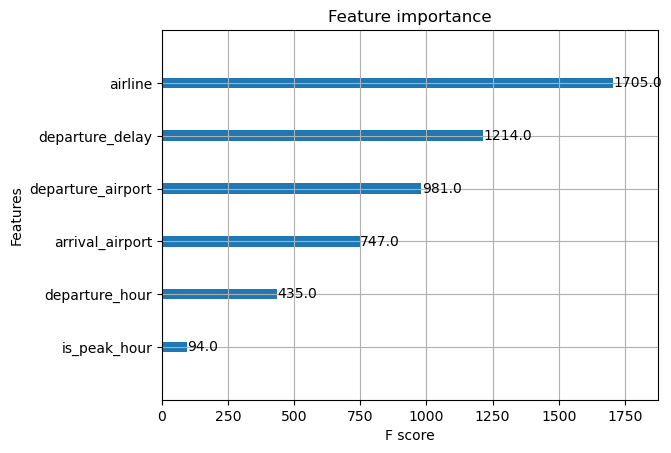

In [312]:
# Feature Importance for Optimized Model
plt.figure(figsize=(10, 6))
xgb.plot_importance(tuned_model,importance_type='weight')
plt.show()

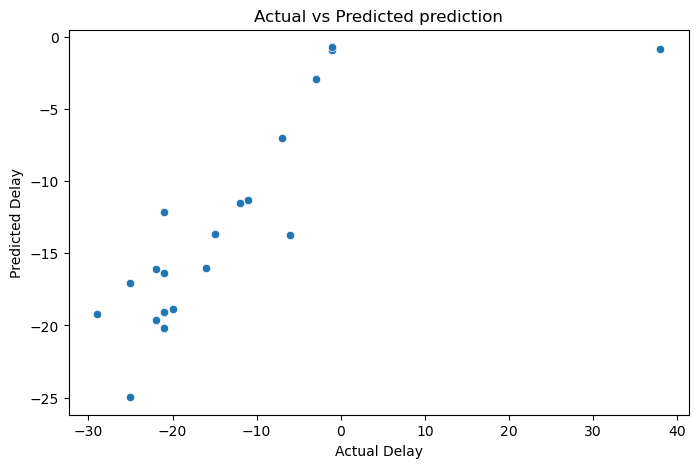

In [313]:
# Updated Scatter plot for optimized predictions
plot_predictions(ytest, y_pred_optimized)